# Metaphoricity Cue Detection

Most of the examples in this notebook demonstrate the preprocessing pipeline for the metaphoricity cue novelisation; unless stated otherwise, the same steps apply to all other metaphoricity cues as well.

## Filtering for Positive Cue Instances

The first step in preprocessing is to filter the dataset by selecting only instances where the relevant cue is annotated as present (i.e. a value of 1). As previously discussed, due to the complexity introduced by merged annotation cells, not all initial annotations for cues such as novelisation were ultimately retained as true positives. Therefore, filtering ensures that only verified instances of the selected cue are included for further processing.

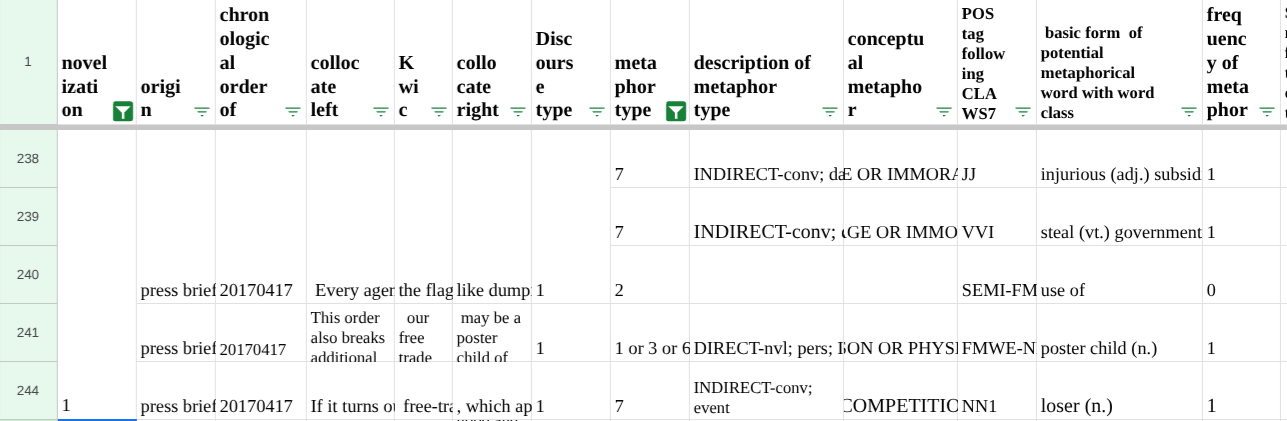

As shown in the above image, applying an initial filter to the novelisation column with a value of 1 yields five positive instances within the same document, namely the White House press briefing from 17 April 2017. However, closer inspection reveals that only one of these instances actually contains a novel metaphor. This discrepancy arises because cue annotations are often applied at the document level, whereas actual metaphoricity may only occur once within a given document.

In this case, we use the ¨description of metaphor type¨ column to resolve the ambiguity. Of the five rows, only row 241 includes the acronym nvl, indicating a novel metaphor. The metaphorical vehicle ¨poster child¨ in the ¨basic form of potential metaphorical word with word class¨ column further confirms this classification, as it constitutes a novel metaphor in the context of trade discourse. Consequently, we manually reduce the five positive entries to a single valid instance of novelisation.

Additionally, duplicate rows containing identical sentences are collapsed into a single entry, despite all being valid cue-positive instances, to prevent the same sentence being evaluated repeatedly during testing. This manual step ensures that the data reflect unique and justified cue occurrences, which is essential for the subsequent experiment to be valid.

## Constructing Evaluation Set

In [ ]:
import pandas as pd

trump = pd.read_excel("Novelisation Trump.xlsx")
clinton = pd.read_excel("Novelisation Clinton.xlsx")
df = pd.concat([trump, clinton], ignore_index=True)

After filtering each corpus (Trump and Clinton) for the specific metaphoricity cue, the code combines the two datasets into a single data frame for unified processing.

In [ ]:
df = df.dropna(subset=['collocate left', 'Kwic', 'collocate right'], how='all')

This line of code removes all rows from the data frame where the ¨collocate left¨, ¨Kwic¨ and ¨collocate right¨ columns are all empty. This is because such rows cannot be preprocessed due to the absence of any retrievable sentence context.

In [ ]:
df['sentence'] = df[['collocate left', 'Kwic', 'collocate right']] \
    .astype(str) \
    .apply(lambda x: ' '.join([word for word in x if word.lower() != 'nan']).strip(), axis=1)

This code creates full sentences by joining the ¨collocate left¨, ¨Kwic¨ and ¨collocate right¨ columns.

In [ ]:
df_novelisation = df[df['novelization'].notna()]
df_no_novelisation = df[df['novelization'].isna()]
#------------------------------------------------------------------------
df_wearing = df[df['frequency of metaphorical word'].fillna(0) > 0]
df_no_wearing = df[df['frequency of metaphorical word'].isna()]

The data frame is split into two subsets: one containing all rows where the ¨novelization¨ column is not empty (positive labels), and one containing all rows where the ¨novelization¨ column is empty (negative labels).

For general metaphor detection, sentences are labelled as metaphorical if the value in the column ¨frequency of metaphorical word¨ is greater than 0; otherwise, they are considered non-metaphorical.

In [ ]:
num_sentences = len(df_novelisation)
print("Total number of novelisation sentences:", num_sentences)
------------------------------------------------------------------------
import numpy as np

df_no_novelisation_filtered = df_no_novelisation.dropna(subset=["conceptual metaphor"])
np.random.seed(49)
sampled_sentences = df_no_novelisation_filtered.sample(n=43)

First, the number of positive instances of novelisation is determined (of which there are 43). Then, an equal number of negative instances is randomly sampled from the dataset of non-novelisation cases.

The same procedure was used for all the other metaphoricity cues. However, novelisation included an additional restriction in the selection of negative cases. Since most conventional metaphors feature unspecified source domains, 50% of the non-novelisation metaphors were specifically chosen to include explicit mappings, thereby making the underlying source domain fully transparent. This enables the model to be tested on metaphors where the metaphorical noun is explicitly stated, to determine whether it is considered novel in its given context.

In [ ]:
from itertools import combinations

sentences = sampled_sentences['sentence'].tolist()
indices = sampled_sentences.index.tolist()

threshold = 0.6
min_match_length = lambda s: int(len(s.split()) * threshold)

similar_pairs = []
num_sentences = len(sentences)

for i, j in combinations(range(num_sentences), 2):
    s1_words = sentences[i].split()
    s2_words = sentences[j].split()

    min_length = min(min_match_length(sentences[i]), min_match_length(sentences[j]))
    if len(set(s1_words) & set(s2_words)) >= min_length:
        similar_pairs.append((indices[i], sentences[i], indices[j], sentences[j]))

print(f"Found {len(similar_pairs)} similar pairs (>= {threshold * 100:.0f}% identical words):\n")
for idx1, s1, idx2, s2 in similar_pairs:
    print(f"Index 1: {idx1} | Sentence 1: {s1}")
    print(f"Index 2: {idx2} | Sentence 2: {s2}")
    print("--------")

While the positive instances were carefully selected to avoid duplicates, it was not feasible to do the same for the negative instances, which were obtained through random sampling. To address this issue, all sentence pairs in the negative dataset were compared to identify cases in which more than 60% of the words were identical. This relatively low threshold was chosen deliberately to ensure that all posible duplicates could be detected and excluded from the final evaluation set.

The output of this code when applied to marking is shown below, since there are no duplicates in novelisation.

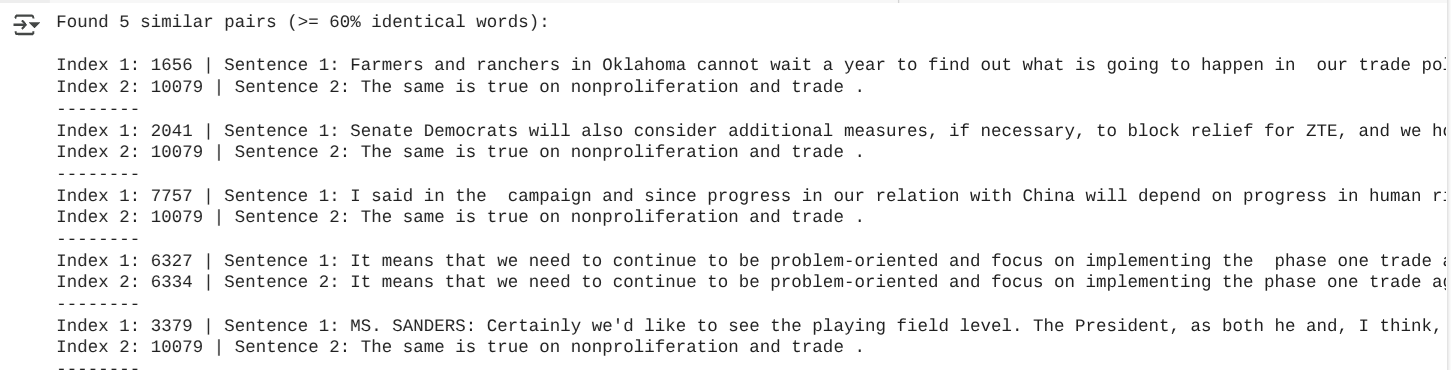

As can be seen from the output above, sentence 10079 appears four times as part of different sentence pairs. This is probably because it is short and contains commonly used words, which increases the probability of high word overlap with unrelated sentences. The fourth pair, consisting of indices 6327 and 6334, not only features consecutive indices (often an indicator that the sentences originate from the same document segment), but the sentences are indeed identical.

In [ ]:
all_indices = set(df_no_marking_filtered.index)

duplicate_indices = set(idx1 for idx1, _, idx2, _ in similar_pairs) | set(idx2 for _, _, idx2, _ in similar_pairs)

available_indices = list(all_indices - duplicate_indices)

np.random.seed(49)
replacement_index = np.random.choice(available_indices)

sampled_sentences.loc[6334, 'sentence'] = df_no_marking_filtered.loc[replacement_index, 'sentence']

print(f"Replaced sentence at index 6334 with sentence from index {replacement_index}.")

In cases where duplicates were detected (such as index 6334), the sentence was replaced with a new negative instance randomly selected from the remaining pool of non-marking instances (in this case, index 1027).

In [ ]:
df_novelisation_labeled = df_novelisation[['sentence']].copy()
df_novelisation_labeled['true label'] = 1

sampled_sentences_labeled = sampled_sentences[['sentence']].copy()
sampled_sentences_labeled['true label'] = 0

combined_df = pd.concat([df_novelisation_labeled, sampled_sentences_labeled], ignore_index=True)

combined_df = combined_df.sample(frac=1, random_state=49).reset_index(drop=True)

The positive and negative instances were combined into a single, balanced dataset that was randomly shuffled using a fixed seed for classification tests.

## Automatic Prompt Generator

In [ ]:
part_sizes = [43, 43]

start_idx = 0
sentence_counter = 1

for part_num, part_size in enumerate(part_sizes, start=1):
    part_sentences = combined_df['sentence'][start_idx:start_idx + part_size]

    print(f"\n### Part {part_num} ###\n")

    for sentence in part_sentences:
        print(f"Metaphor {sentence_counter}: Is there novelization in the metaphor '{sentence}'?")
        sentence_counter += 1

    start_idx += part_size

    print("\n" + "-" * 50 + "\n")

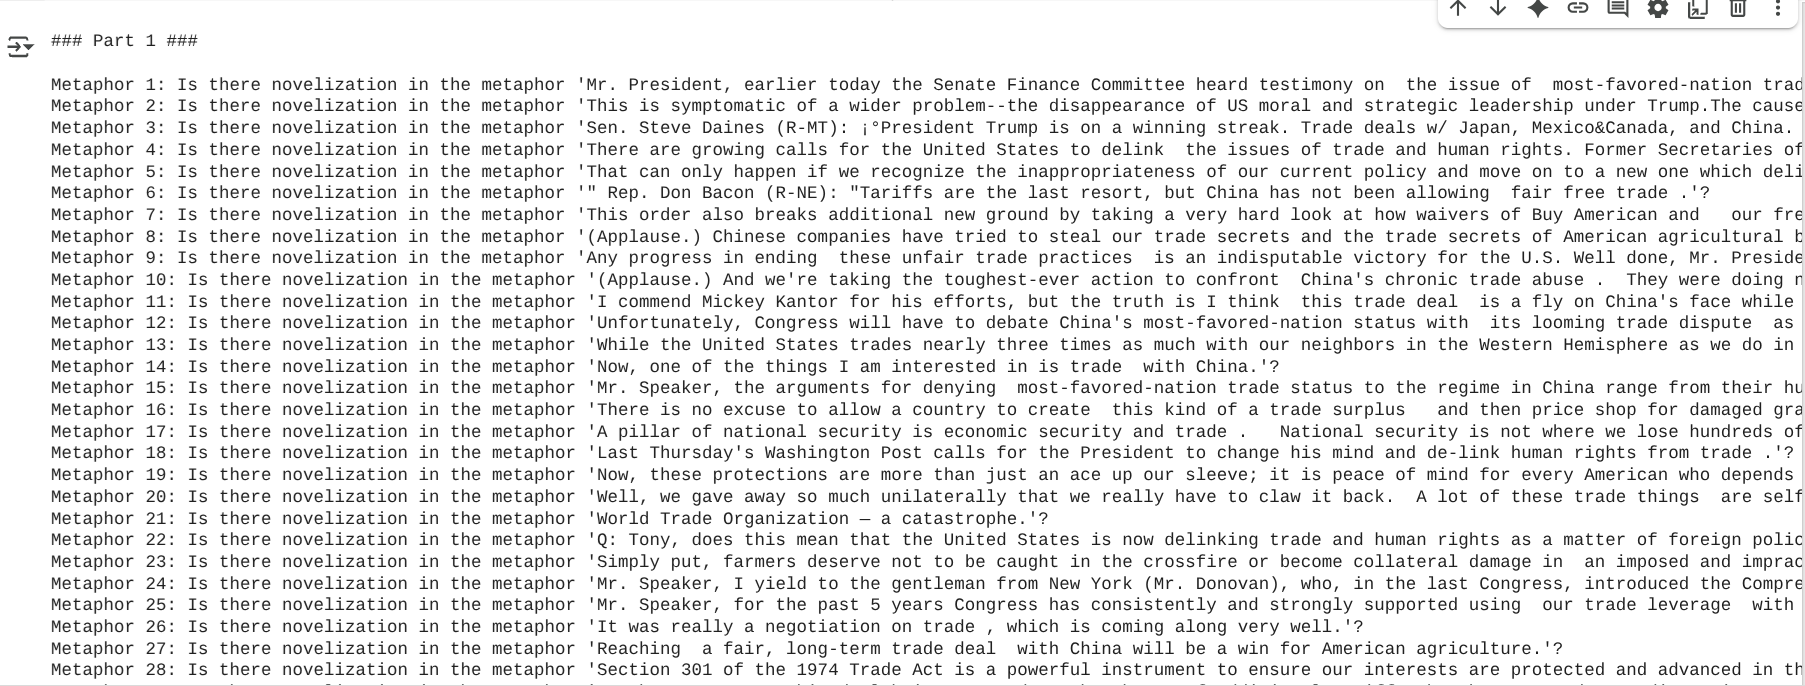

To save time, this script automatically generates prompts by combining multiple metaphors into a single, structured format. This allows metaphors to be efficiently grouped into prompt segments (e.g. 43 per prompt), making them easier to input into GPT.

## Evaluation Metrics

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

df_results = pd.read_excel("Novelisation Results.xlsx")

true_labels = df_results['true label']
pred_o4_mini = df_results['o4-mini']
pred_o4_high = df_results['o4-high']
pred_o3 = df_results['o3']

accuracy_o4_mini = accuracy_score(true_labels, pred_o4_mini)
f1_o4_mini = f1_score(true_labels, pred_o4_mini)

accuracy_o4_high = accuracy_score(true_labels, pred_o4_high)
f1_o4_high = f1_score(true_labels, pred_o4_high)

accuracy_o3 = accuracy_score(true_labels, pred_o3)
f1_o3 = f1_score(true_labels, pred_o3)

print(f"o4_mini Accuracy: {accuracy_o4_mini:.4f}")
print(f"o4_mini F1 Score: {f1_o4_mini:.4f}")

print(f"o4_high Accuracy: {accuracy_o4_high:.4f}")
print(f"o4_high F1 Score: {f1_o4_high:.4f}")

print(f"o3 Accuracy: {accuracy_o3:.4f}")
print(f"o3 F1 Score: {f1_o3:.4f}")

The accuracy and F1 scores for all three OpenAI o-series models are based on the predictions stored in the predictions map. The full results are reported in the main paper.